In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pprint
pp = pprint.PrettyPrinter(indent=4)

import acctrack.utils.ctd2021_data as data_helper
from acctrack.io.athena_raw_root import AthenaRawRootReader
from acctrack.tools.compare_tracking_algs import TrackAlgComparator
from acctrack.tools.analyze_track_data import TrackAnalyzer


In [3]:
run_number = 242020
event_number = 6800

## Read the data

In [4]:
gnn_path = "/pscratch/sd/x/xju/ITk/ForFinalPaper/run_athena/run/GNN4Pixel"
gnn_reader = AthenaRawRootReader(gnn_path, debug=True, name="GNNReader")
gnn_reader.read_file(0)

Tree GNN4ITk is not in /pscratch/sd/x/xju/ITk/ForFinalPaper/run_athena/run/GNN4Pixel/physval.root
Tree GNN4ITk is not in /pscratch/sd/x/xju/ITk/ForFinalPaper/run_athena/run/GNN4Pixel/test.aod.gnnreader.debug.root
Directory: /pscratch/sd/x/xju/ITk/ForFinalPaper/run_athena/run/GNN4Pixel contains  1 files and total 1 events.
Reading file: /pscratch/sd/x/xju/ITk/ForFinalPaper/run_athena/run/GNN4Pixel/Dump_GNN4Itk.root
Number of events: 1 in file /pscratch/sd/x/xju/ITk/ForFinalPaper/run_athena/run/GNN4Pixel/Dump_GNN4Itk.root.


[6800]

In [5]:
gnn_reader.read(event_number)
gnn_reader.match_to_truth()

All matched to truth GNNReader:  1349 1740 0.7752873563218391


,trkid,num_matched,subevent,barcode,true_pixel_hits,true_sct_hits,reco_pixel_hits,reco_sct_hits,common_pixel_hits,common_sct_hits
0,0,3,6800,446,6,9,6,9,6,9
1,1,1,6800,10043,12,2,8,2,8,2
2,2,1,441,10202,10,0,10,0,10,0
3,3,1,425,11007,12,0,12,0,12,0
4,4,1,490,10380,12,0,12,0,12,0
...,...,...,...,...,...,...,...,...,...,...
1713,1488,1,453,10279,11,0,11,0,11,0
1714,1489,1,6800,816,10,8,3,8,3,8
1715,1490,1,432,10725,8,13,3,10,3,10
1723,1494,1,420,10369,14,0,10,0,10,0


In [6]:
ckf_path = "/pscratch/sd/x/xju/ITk/ForFinalPaper/run_athena/run/ckfOneEvt"
ckf_reader = AthenaRawRootReader(ckf_path, debug=True, name="CKFReader")
ckf_reader.read_file(0)

Tree GNN4ITk is not in /pscratch/sd/x/xju/ITk/ForFinalPaper/run_athena/run/ckfOneEvt/physval.root
Tree GNN4ITk is not in /pscratch/sd/x/xju/ITk/ForFinalPaper/run_athena/run/ckfOneEvt/test.aod.ckf.debug.root
Directory: /pscratch/sd/x/xju/ITk/ForFinalPaper/run_athena/run/ckfOneEvt contains  1 files and total 1 events.
Reading file: /pscratch/sd/x/xju/ITk/ForFinalPaper/run_athena/run/ckfOneEvt/Dump_GNN4Itk.root
Number of events: 1 in file /pscratch/sd/x/xju/ITk/ForFinalPaper/run_athena/run/ckfOneEvt/Dump_GNN4Itk.root.


[6800]

In [7]:
ckf_reader.read(event_number)
ckf_reader.match_to_truth()

All matched to truth CKFReader:  1432 1893 0.7564712097200211


,trkid,num_matched,subevent,barcode,true_pixel_hits,true_sct_hits,reco_pixel_hits,reco_sct_hits,common_pixel_hits,common_sct_hits
0,0,1,474,10246,14,13,14,13,14,13
2,1,1,506,10193,27,0,26,0,26,0
3,2,1,563,11035,15,12,15,12,15,12
4,3,1,444,10310,21,2,21,2,21,2
5,4,1,538,10432,21,2,21,2,21,2
...,...,...,...,...,...,...,...,...,...,...
1868,1590,1,548,200082,4,8,3,8,3,8
1869,1591,1,432,10316,5,8,2,8,2,8
1870,1592,1,563,200427,2,8,2,8,2,8
1871,1593,3,423,10382,9,9,2,7,2,7


In [8]:
print("GNN")
print(gnn_reader.detailed_matching['num_matched'].value_counts())
print("CKF")
print(ckf_reader.detailed_matching['num_matched'].value_counts())

GNN
num_matched
1    1572
2     157
3      10
4       1
Name: count, dtype: int64
CKF
num_matched
1    1679
2     195
3      15
4       3
9       1
Name: count, dtype: int64


## Compare GNN with CKF

In [9]:
compare_gnn_ckf = TrackAlgComparator(gnn_reader, ckf_reader)

### Common Tracks

1503 GNNReader tracks compared to 1604 CKFReader tracks.
Require min_num_clusters = 5 only for GNNReader tracks.
Total # of GNNReader tracks: 1503. After filtering, # of GNNReader tracks: 1503 (100.000%)
Matched: 894, 1503, 0.5948
GNNReader is a subset: 262, 1503, 0.1743
CKFReader is a subset: 70, 1503, 0.0466
Disjoint:  180, 1503, 0.1198


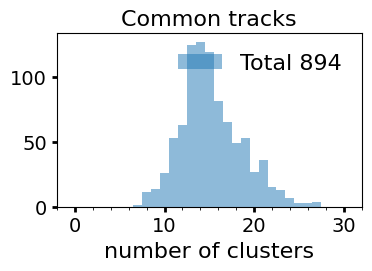

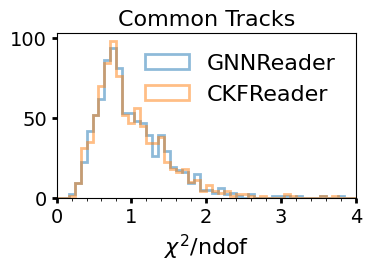

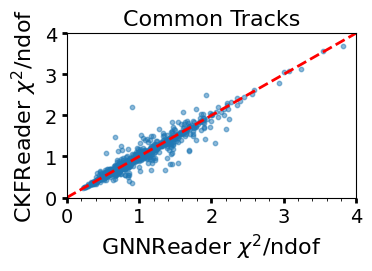

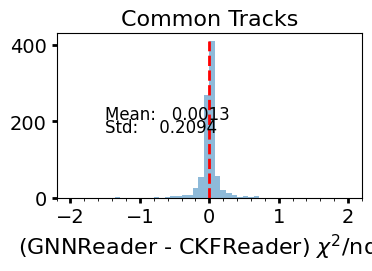

In [10]:
gnn_chi2, ckf_chi2 = compare_gnn_ckf.plot_common_tracks()

### Disjoint tracks

All matched to truth GNNReader:  1349 1740 0.7752873563218391
All matched to truth CKFReader:  1432 1893 0.7564712097200211
1604 CKFReader tracks compared to 1503 GNNReader tracks.
Require min_num_clusters = 5 only for CKFReader tracks.
Total # of CKFReader tracks: 1604. After filtering, # of CKFReader tracks: 1604 (100.000%)
Matched: 894, 1604, 0.5574
CKFReader is a subset: 70, 1604, 0.0436
GNNReader is a subset: 255, 1604, 0.1590
Disjoint:  293, 1604, 0.1827
1503 GNNReader tracks compared to 1604 CKFReader tracks.
Require min_num_clusters = 5 only for GNNReader tracks.
Total # of GNNReader tracks: 1503. After filtering, # of GNNReader tracks: 1503 (100.000%)
Matched: 894, 1503, 0.5948
GNNReader is a subset: 262, 1503, 0.1743
CKFReader is a subset: 70, 1503, 0.0466
Disjoint:  180, 1503, 0.1198


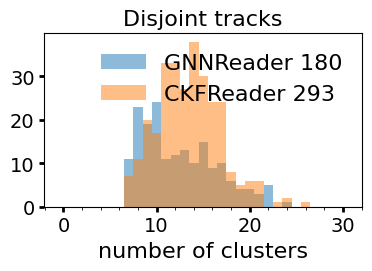

Number of good disjoint GNNReader tracks: 149 / 180
Number of good disjoint CKFReader tracks: 245 / 293


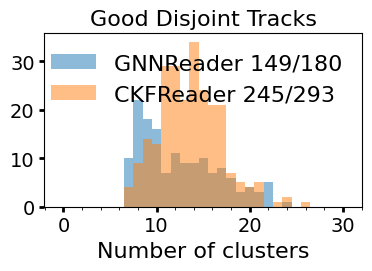

AttributeError: 'DataFrame' object has no attribute 'particle_id'

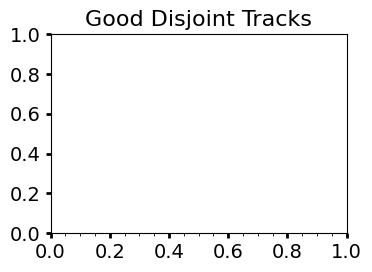

In [11]:
gnn_good_disjoints, ckf_good_disjoints, \
gnn_good_disjoints_matched_particles, ckf_good_disjoints_matched_particles \
        = compare_gnn_ckf.plot_disjoint_tracks()

### Good Disjoint Tracks from CKF with pT > 1 GeV
There are 36 tracks only found by CKF and matched to true particles with pT > 1 GeV. However, the track contents of those tracks are not used at all by GNN. Let's look at the details of these tracks. 

In [ ]:
pt_ckf = ckf_good_disjoints_matched_particles.pt.values

ckf_matched_pids = ckf_good_disjoints_matched_particles[pt_ckf > 1000].particle_id.values
ckf_disjoints_good_match = ckf_good_disjoints[ckf_good_disjoints.particle_id.isin(ckf_matched_pids)]

good_ckf_only_clusters = [ckf_reader.tracks_clusters[x] for x in ckf_disjoints_good_match.trkid.values]
good_ckf_only_clusters = np.array([item for sublist in good_ckf_only_clusters for item in sublist], dtype=int)
good_ckf_only_cluster_info = ckf_reader.clusters[ckf_reader.clusters.cluster_id.isin(good_ckf_only_clusters)]
good_ckf_only_cluster_info = good_ckf_only_cluster_info.assign(
    cluster_r=np.sqrt(good_ckf_only_cluster_info.cluster_x**2 + good_ckf_only_cluster_info.cluster_y**2))


In [ ]:
plt.title("Good disjoint tracks from CKF only, pT > 1 GeV")
plt.hist2d(good_ckf_only_cluster_info.cluster_z, good_ckf_only_cluster_info.cluster_r, bins=100, range=((-4000, 4000), (0, 1200)))
plt.xlabel("cluster z [mm]")
plt.ylabel("cluster r [mm]")
plt.colorbar()


In [ ]:
print(compare_gnn_ckf.common_track_indices[0])
print(compare_gnn_ckf.common_track_indices[4])
print("{:.6f}, {:.6f}".format(gnn_chi2[0], ckf_chi2[0]))
print("{:.6f}, {:.6f}".format(gnn_chi2[4], ckf_chi2[4]))

In [ ]:
import uproot
import pandas as pd
from acctrack.io import utils_athena_raw_root as utils_raw_root
from acctrack.io import utils_athena_raw as utils_raw_csv

tree_name = "GNN4ITk"
in_file_name = "/pscratch/sd/x/xju/ITk/ForFinalPaper/run_athena/run/GNN4Pixel/Dump_GNN4Itk.root"

tree = uproot.open(in_file_name)[tree_name]

In [ ]:
tracks_info = tree.arrays(utils_raw_root.reco_track_sp_branch_names)[0]